In [11]:
import tensorflow as tf
tf.reset_default_graph()

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [13]:
import matplotlib.pyplot as plt

7


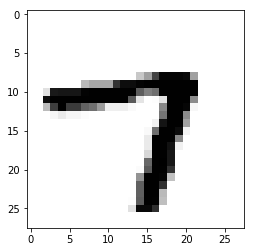

In [14]:
image, label = mnist.train.next_batch(1)
%matplotlib inline
print(label[0])
plt.imshow(image[0].reshape(28,28), cmap='Greys')

In [15]:
def discriminator(x, reuse=False):
    with tf.variable_scope("D"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        w1 = tf.get_variable("w1", [5, 5, 1, 32], initializer = tf.truncated_normal_initializer())
        b1 = tf.get_variable("b1", [32], initializer = tf.truncated_normal_initializer())
        h1 = tf.nn.relu(tf.nn.conv2d(x, w1, [1, 2, 2, 1], "SAME") + b1)
        
        w2 = tf.get_variable("w2", [5, 5, 32, 64], initializer = tf.truncated_normal_initializer())
        b2 = tf.get_variable("b2", [64], initializer = tf.truncated_normal_initializer())
        h2 = tf.nn.relu(tf.nn.conv2d(h1, w2, [1, 2, 2, 1], "SAME") + b2)
        
        w3 = tf.get_variable("w3", [5, 5, 64, 128], initializer = tf.truncated_normal_initializer())
        b3 = tf.get_variable("b3", [128], initializer = tf.truncated_normal_initializer())
        h3 = tf.nn.relu(tf.nn.conv2d(h2, w3, [1, 2, 2, 1], "SAME") + b3)
                
        w4 = tf.get_variable("w4", [5, 5, 128, 256], initializer = tf.truncated_normal_initializer())
        b4 = tf.get_variable("b4", [256], initializer = tf.truncated_normal_initializer())
        h4 = tf.nn.relu(tf.nn.conv2d(h3, w4, [1, 2, 2, 1], "SAME") + b4)
        h4 = tf.reshape(h4, [-1, 256])
        
        w5 = tf.get_variable("w5", [256, 1], initializer = tf.truncated_normal_initializer())
        b5 = tf.get_variable("b5", [1], initializer = tf.truncated_normal_initializer())
        return tf.matmul(h4, w5) + b5

In [16]:
def generator(z, zdim, batch_size, reuse=False):
    with tf.variable_scope("G"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()

        w1 = tf.get_variable("w1", [zdim, 784], initializer = tf.truncated_normal_initializer())
        b1 = tf.get_variable("b1", [784], initializer = tf.truncated_normal_initializer())
        h1 = tf.nn.relu(tf.tf.matmul(z, w1) + b1)
        h1 = tf.reshape(h1, [batch_size, 28, 28, 1])
        h1 = tf.contrib.layers.batch_norm(h1)     
        
        return tf.sigmoid(h1)


In [18]:
x_placeholder = tf.placeholder(tf.float32, [None, 28, 28, 1], name="x")
z_placeholder = tf.placeholder(tf.float32, [None, None], name="z")

In [19]:
session = tf.Session()
Dx = discriminator(x_placeholder)
Gz = generator(z_placeholder, 100, 100, False)
Dg = discriminator(Gz, True)

In [20]:
d_cost_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_cost_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
g_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [21]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'D/' in var.name]
g_vars = [var for var in tvars if 'G/' in var.name]

In [22]:
optimizer_d_real = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_real, var_list=d_vars)
optimizer_d_fake = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_fake, var_list=d_vars)
optimizer_g = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_cost, var_list=g_vars)

3702.01
184964.0


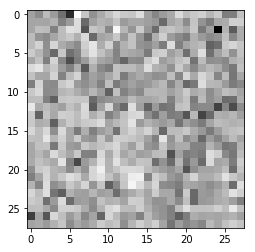

335.156
16411.4
947.548
3545.95
880.156
7224.42
1413.14
2194.34
1369.23
32030.1


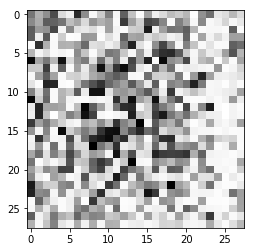

1966.99
93655.7
4148.48
8567.08
3450.02
68757.3
1836.85
16031.7
2795.24
119344.0


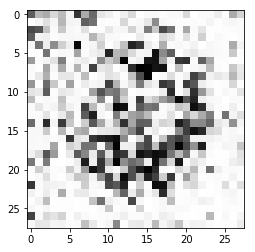

3718.91
110799.0


KeyboardInterrupt: 

In [23]:
import numpy as np
import datetime
session.run(tf.global_variables_initializer())

batch_size = 100
z_dimensions = 100
for i in range(10000):
    real_image_batch, _ = mnist.train.next_batch(batch_size)
    real_image_batch = real_image_batch.reshape([-1, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _, __, d_loss_real, d_loss_fake = session.run([optimizer_d_real, optimizer_d_fake, d_cost_real, d_cost_fake],
                                           {x_placeholder: real_image_batch, z_placeholder:z_batch})
    
    _ = session.run([optimizer_g], feed_dict={z_placeholder:z_batch})

    if i % 20 == 0:
        print d_loss_real
        print d_loss_fake
    if i % 100 == 0:
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, z_dimensions, 1, True)
        images = session.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()